In [1]:
!pip install cantera

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.1/19.1 MB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.6/118.6 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 739.1/739.1 kB 13.5 MB/s eta 0:00:00


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import solve_ivp
import sympy as smp
import cantera as ct
import scipy.optimize as opt

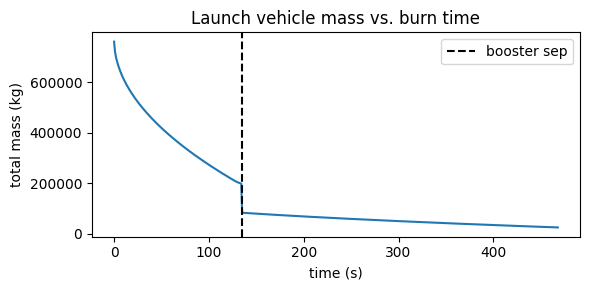

In [3]:
gas = ct.Solution('h2o2.yaml')

# 1.  Define chamber conditions and mixture ratio
Pc   = 117*ct.one_atm          # chamber pressure [Pa]
Tc   = 3500.0         # guess for Tchamber [K]
MR   = 6.03            # oxidiser-to-fuel mass ratio
P_e = 0.5 * ct.one_atm # assumed constant

# 2.  Make an equilibrium “chamber gas”
gas.TP = Tc, Pc
gas.set_equivalence_ratio(phi=1/MR, fuel='H2', oxidizer='O2:1, N2:0')
gas.equilibrate('HP')                 # constant H,P

# geometric area ratios
eps_c = 60           # core nozzle  A_e/A_t
eps_b = 14.5           # booster nozzle

gamma = gas.cp / gas.cv
R     = ct.gas_constant / gas.mean_molecular_weight   # J kg-1 K-1

# helper: solve Me from epr (ideal, isentropic, frozen)
def mach_from_eps(eps, gamma, M_guess=5):
    def f(M):
        term = (2/(gamma+1)) * (1 + (gamma-1)/2 * M**2)
        return (1/M) * term**((gamma+1)/(2*(gamma-1))) - eps
    return opt.newton(f, M_guess, maxiter=50)

# core
Me_c  = mach_from_eps(eps_c, gamma)
Pe_c  = Pc * (1 + (gamma-1)/2 * Me_c**2)**(-gamma/(gamma-1))
Te_c  = Tc / (1 + (gamma-1)/2 * Me_c**2)
ve_c  = Me_c * (gamma*R*Te_c) ** 0.5 # m s-1

# booster
Me_b  = mach_from_eps(eps_b, gamma)
Pe_b  = Pc * (1 + (gamma-1)/2 * Me_b**2)**(-gamma/(gamma-1))
Te_b  = Tc / (1 + (gamma-1)/2 * Me_b**2)
ve_b  = Me_b * (gamma*R*Te_b)**0.5 # m s-1

# 3. Calculate the velocities for booster and core
vg_core    = ve_c    # reference velocity for the core segment
vg_booster = ve_b    # reference velocity for booster thrust terms


g = 9.81
vg = np.maximum(vg_core, vg_booster) #
#vg = 8000
A_ref_core = np.pi * (5.4 * 62) # cylindrical surface area in m2
A_ref_booster = np.pi * (3.4 * 13.5)


T0b = 135 # s  (boosters)
T0c = 468 # s  (core, used as master scale)

gT_vg = g * T0b / vg         # appears often so pre-compute
drag_group = 0


def z_curve(tau, n): # given mass depletion rate
    return 1 - 0.9 * tau**n

def dzdt_curve(tau, n):
    return -0.9 * n * tau**(n-1)


m_dry_b  = 11000        # kg  per booster
m_prop_b = 142000       # kg  ”     ”
m_dry_c  = 10000      # kg  core stage hardware + second stage
m_prop_c = 140000      # kg  core propellant
m_payload = 8500      # kg max payload for lunar transfer

n_b = 0.5      # front loaded booster
n_c = 0.5      # core front-loaded a bit


# 4. Rocket ODE system

def dSdt(tau, S):
    x, v, zb, zc = S

    # propellant curves
    if tau < T0b/T0c: # boosters firing
        zb  = z_curve(tau / (T0b/T0c), n_b)
        dzb = dzdt_curve(tau / (T0b/T0c), n_b) / (T0b/T0c)
        m_prop_booster = 4 * m_prop_b * zb # still on board
        m_dry_booster  = 4 * m_dry_b
    else: # boosters jettisoned
        dzb = 0.0
        m_prop_booster = 0.0
        m_dry_booster  = 0.0

    if tau < 1.0: # core burning
        zc  = z_curve(tau, n_c)
        dzc = dzdt_curve(tau, n_c)
    else: # core out
        dzc = 0.0
        zc  = 0.1
    m_prop_core = m_prop_c * zc

    # total mass
    m_tot = m_dry_booster + m_dry_c + m_prop_booster + m_prop_core + m_payload
    thrust_acc = (4 * (-dzb) + (-dzc)) * vg / m_tot
    # Drag
    area = A_ref_core + (0 if tau>T0b/T0c else 4*A_ref_booster)
    drag_acc = drag_group * area * (-v*abs(v)) / m_tot
    # ODE
    dxdt = v
    dvdt = thrust_acc + drag_acc - gT_vg
    # Ground contact clipping
    if (x<=0) and (v<0):   dxdt = dvdt = 0
    return [dxdt, dvdt, dzb, dzc]


S0 = [0.0, 0.0, 1.0, 1.0]
sol = solve_ivp(dSdt, [1e-4, 1], y0=S0,
                t_eval=np.linspace(1e-4, 1, 500))


# 5. post-process mass
tau   = sol.t # dimensionless time
t_sec = tau * T0c # real seconds

zb = sol.y[2] # booster mass fraction history
zc = sol.y[3] # core mass fraction history
booster_live = tau < T0b/T0c

m_tot = (m_dry_c
         + m_prop_c * zc
         + np.where(booster_live,
                    4*m_dry_b + 4*m_prop_b*zb,
                    0.0))


# 6. Plot
fig, ax = plt.subplots(figsize=(6,3))

ax.plot(t_sec, m_tot)                 # kg
ax.set_xlabel('time (s)')
ax.set_ylabel('total mass (kg)')
ax.set_title('Launch vehicle mass vs. burn time')
ax.axvline(T0b, ls='--', color='k', label='booster sep')
ax.legend()

plt.tight_layout()
plt.show()


# 1)  Convert the dimensionless state variables to real units IGNORE
#
#   v  and x in the integrator are *scaled* by the reference velocity vg
#   and time scale T0c, so undo that scaling before plotting.
# alt_m   = sol.y[0] * vg * T0c      # altitude  (m)
# vel_mps = sol.y[1] * vg            # velocity  (m/s)






